## Import Library

In [7]:
import numpy as np
import pandas as pd

#from sklearn.datasets import load_boston
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

#plt.rcParams['figure.figsize'] = [20, 7]

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## load dataset

In [9]:
data = pd.read_csv(r'/content/drive/MyDrive/comm_med_gfr/kidney_transplantation_work_pipeline_17_05_2023/hyper_param_classification_02102024/one_rejection_classification/one_rejection_classification/kidn_class30re_orig.csv')

In [10]:
data.head()

,do_age,gfr_in,speed,Y
0,55.0,114.18,-0.181268,0
1,54.0,86.99,0.187909,0
2,72.0,32.83,-0.117586,1
3,52.0,55.14,0.165242,0
4,53.0,100.70,-0.278593,0


In [11]:
data.shape
data.Y.value_counts()

,count
Y,
0,230
1,30


In [12]:
# separate failures and non failures
data_0 = data[data['Y'] == 0]
data_1 = data[data['Y'] == 1]

In [13]:
data_0=data.sample(n=230)

In [14]:
data = pd.concat([data_0,data_1])

data.Y.value_counts()

,count
Y,
0,202
1,58


In [15]:
# check the number of 1s and 0s
count = data['Y'].value_counts()

print('Failed "1" :', count[1])
print('Not Failed "0":', count[0])

# print the percentage of question where target == 1
print(count[1]/count[0]* 100)

Failed "1" : 58
Not Failed "0": 202
28.71287128712871


In [16]:
# check for null values
data.isnull().sum()

,0
do_age,0
gfr_in,0
speed,0
Y,0


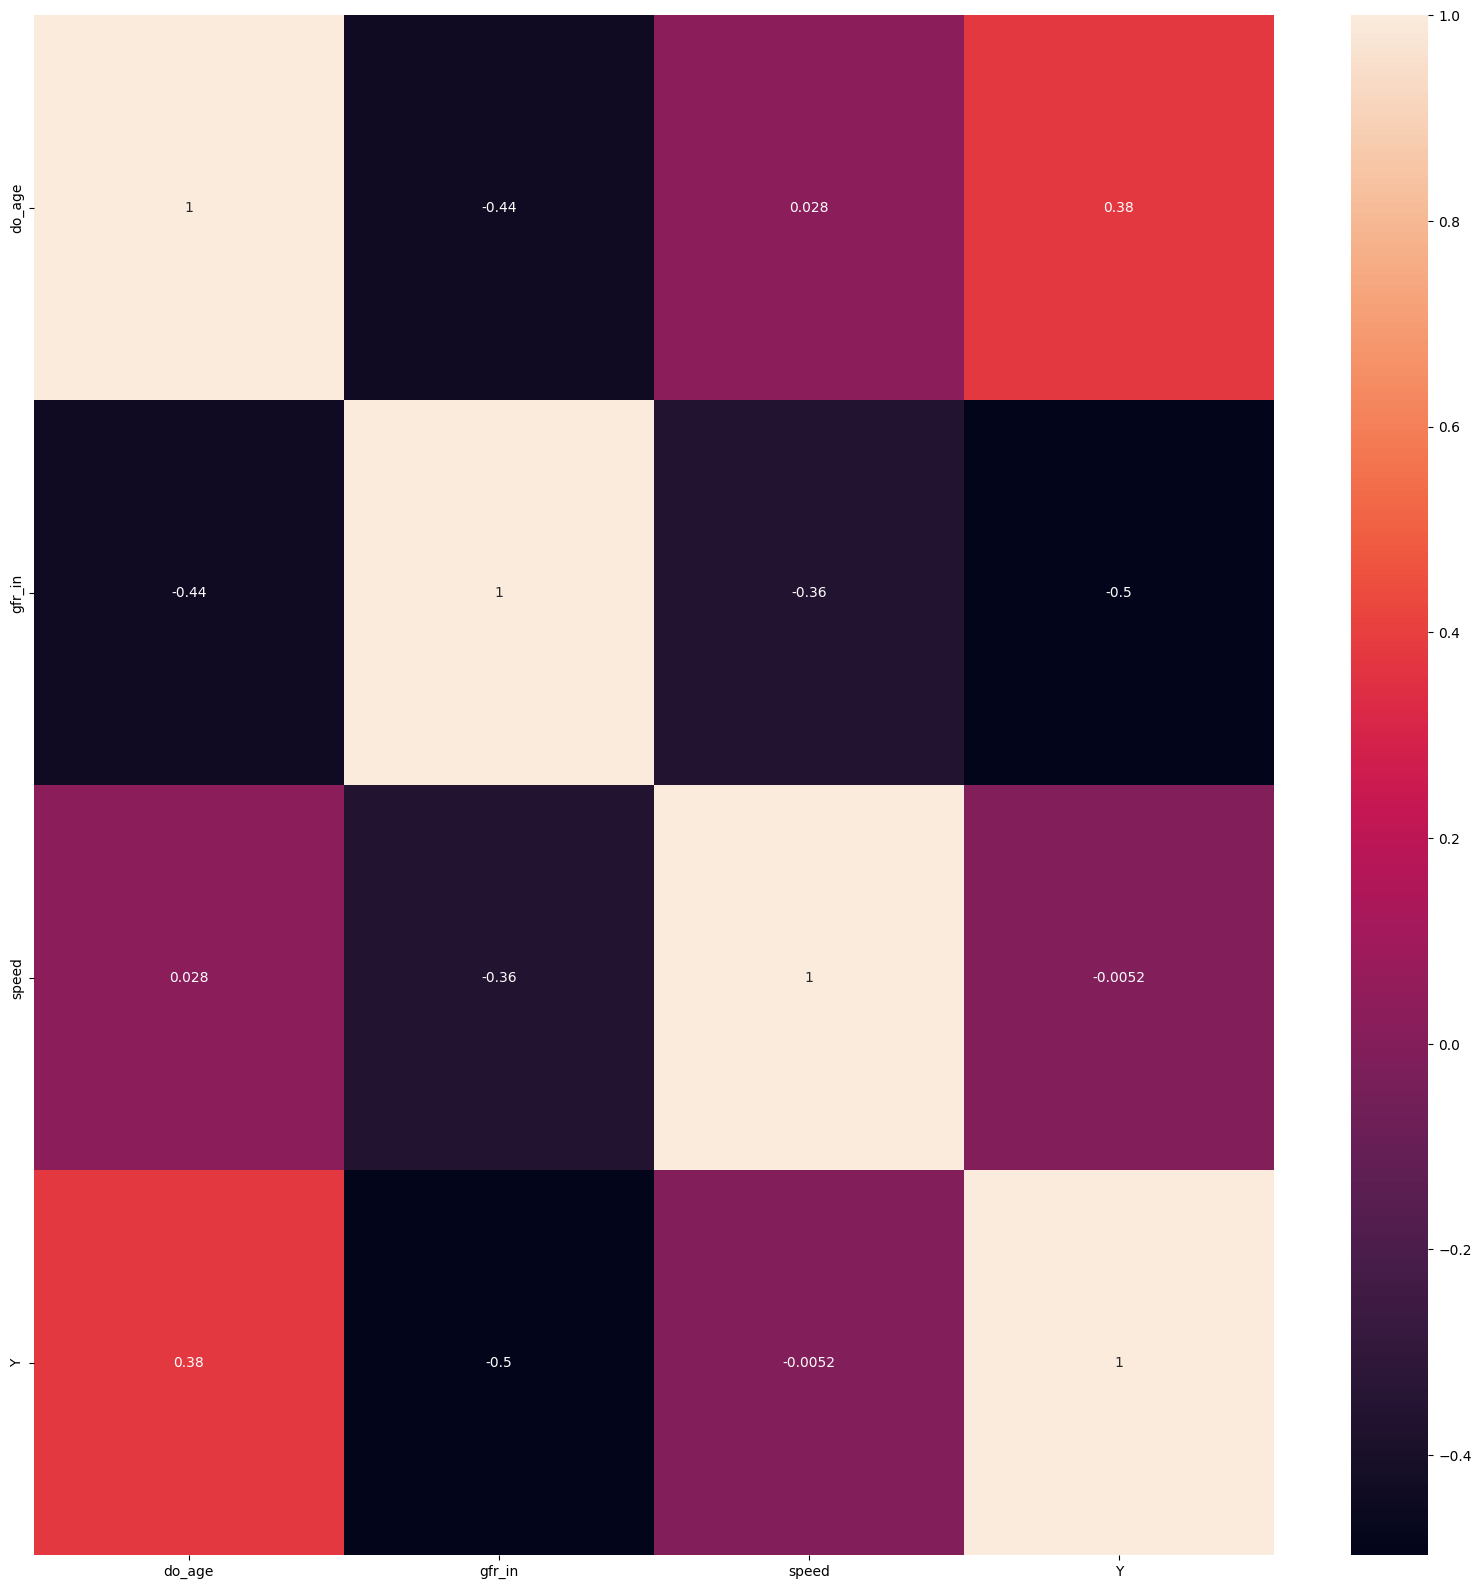

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True)
plt.show()

## Respose and Target variable

In [18]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

# check length of 1's and 0's
one = np.where(y==1)
zero = np.where(y==0)
len(one[0]), len(zero[0])

(58, 202)

## Train test split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Fit the model uing Logitic Regression

In [20]:
# create the object
model =  LogisticRegression()

model.fit(x, y)

y_predict = model.predict(x)

In [21]:
accuracy_score(y_predict, y)

0.8576923076923076

In [22]:
np.unique(y_predict)

array([0, 1])

## The matrix trap

In [23]:
# import linrary
from xgboost import XGBClassifier

xgb_model = XGBClassifier().fit(x_train, y_train)

# predict
xgb_y_predict = xgb_model.predict(x_test)

# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)

print('Accuracy score is:', xgb_score)
print('Roc auc scote:', roc_auc_score(xgb_y_predict, y_test))
print('F1 core:',f1_score(xgb_y_predict, y_test))

Accuracy score is: 0.8974358974358975
Roc auc scote: 0.8395989974937343
F1 core: 0.7894736842105263


In [24]:
confusion_matrix(xgb_y_predict, y_test)

array([[55,  2],
       [ 6, 15]])

##  Resampling Technique

In [25]:
# class count
class_count_0, class_count_1 = data['Y'].value_counts()

# divie class
class_0 = data[data['Y'] == 0]
class_1 = data[data['Y'] == 1]

In [26]:
# print the shape of the class
print('class 0:', class_0.shape)
print('\nclass 1:', class_1.shape)

class 0: (202, 4)

class 1: (58, 4)


## 1. Random under sampling

total class of 1 and 0:
 Y
0    58
1    58
Name: count, dtype: int64


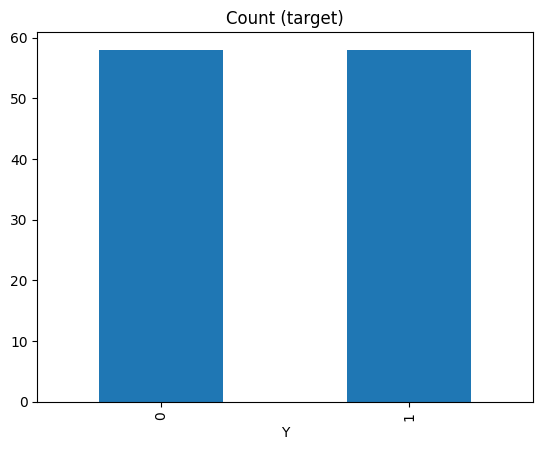

In [27]:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and 0:\n",test_under['Y'].value_counts())

test_under['Y'].value_counts().plot(kind='bar', title='Count (target)')
plt.show()

## 2. Random over sampling

class count of 1 and 0:
 Y
1    202
0    202
Name: count, dtype: int64


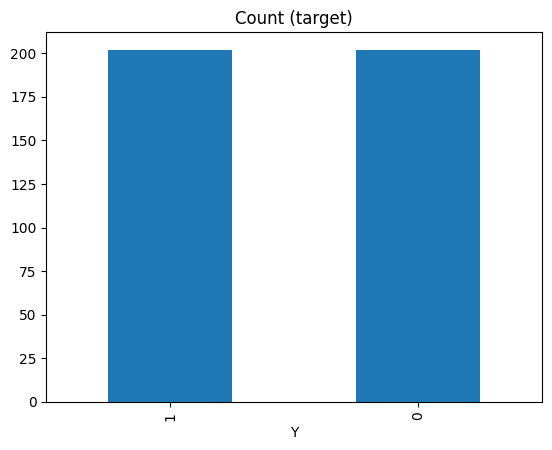

In [28]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_under = pd.concat([class_1_over, class_0], axis=0)

# print the number of class count
print('class count of 1 and 0:\n', test_under['Y'].value_counts())

# plot the count
test_under['Y'].value_counts().plot(kind='bar', title='Count (target)')
plt.show()

## Balance data with imbalance learn module

In [29]:
# import library
import imblearn

## 3. Random under-sampling with imblearn

In [30]:
# import library
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)

# fit predictor and target varialbe
x_rus, y_rus = rus.fit_resample(x, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 202, 1: 58})
Resample dataset shape Counter({0: 58, 1: 58})


## 4.Random over-sampling with imblearn

In [31]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target varaible
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 202, 1: 58})
Resample dataset shape Counter({0: 202, 1: 202})


## 5. under-sampling Tomek links

## 6. Synthetic minority over-sampleing technique

In [32]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit target and predictor variable
x_smote , y_smote = smote.fit_resample(x, y)

print('Origianl dataset shape:', Counter(y))
print('Resampple dataset shape:', Counter(y_smote))

Origianl dataset shape: Counter({0: 202, 1: 58})
Resampple dataset shape: Counter({0: 202, 1: 202})


## 7. NearMiss

In [33]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

x_nm, y_nm = nm.fit_resample(x, y)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_nm))

Original dataset shape: Counter({0: 202, 1: 58})
Resample dataset shape: Counter({0: 58, 1: 58})


## 8. Change the performance metric

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from xgboost import XGBClassifier

# Split the data
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_nm, y_nm, test_size=0.30, random_state=42)

# Define the model
m = XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=m, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the GridSearchCV
grid_search.fit(x_train1, y_train1)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict using the best model
predict_y = best_model.predict(x_test1)

# Print the scores
print('Best Parameters:', grid_search.best_params_)
print('ROCAUC score:', roc_auc_score(y_test1, predict_y))
print('Accuracy score:', accuracy_score(y_test1, predict_y))
print('F1 score:', f1_score(y_test1, predict_y))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
ROCAUC score: 0.7666666666666666
Accuracy score: 0.7428571428571429
F1 score: 0.7567567567567568


## 9. Tree based algorithm

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Load and split the data
x_train, x_test, y_train, y_test = train_test_split(x_nm, y_nm, test_size=0.30, random_state=42)

# Define the model
rfc = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the GridSearchCV
grid_search.fit(x_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict using the best model
rfc_predict = best_model.predict(x_test)

# Print the scores
print('Best Parameters:', grid_search.best_params_)
print('ROCAUC score:', roc_auc_score(y_test, rfc_predict))
print('Accuracy score:', accuracy_score(y_test, rfc_predict))
print('F1 score:', f1_score(y_test, rfc_predict))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
ROCAUC score: 0.875
Accuracy score: 0.8571428571428571
F1 score: 0.8571428571428571


In [36]:
# check performance

print('ROCAUC score:',roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',accuracy_score(y_test, rfc_predict))
print('F1 score:',f1_score(y_test, rfc_predict))

ROCAUC score: 0.875
Accuracy score: 0.8571428571428571
F1 score: 0.8571428571428571
